<a href="https://colab.research.google.com/github/mahnoorn23/CSC2031CourseworkCode/blob/master/Coursework/CSC3831_Final_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC3831 Final Assessment - Part I: Data Engineering



In [1]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
# Loading in the corrupted dataset to be used in analysis and imputation
houses_corrupted = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv', header=0)
# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


Using material and the concepts learnt from the practicals, I applied the initial steps for understanding the data. I used data.head(10) to observe the first 10 rows of that data and inferred their data types for clearer understanding and observed that all of the attributes are numeric.

In [2]:
houses_corrupted.head(10)

df_orig = houses_corrupted.copy()

Using data.describe() I got the Five Number Summary for better statistical analysis. Additionally, I generated the Pairs plot to get an overview of the data as a single set. From these plots, it can be inferred that median_income vs median_house_value has a positive correlation as the values are clustered together somewhat linearly. This would indicate that areas with a higher income tend to have a higher house value. There is a similar correlation for total rooms vs total bedrooms, indicating that generally more rooms means more bedrooms, and for population vs households, indicating a higher population means more households. Furthermore, median_income may be right skewed which would indicate a small number of wealthy areas.

In [3]:
houses_corrupted.describe()

median_house_value  median_income  housing_median_age   total_rooms  \
count        20640.000000   18576.000000        18576.000000  20640.000000   
mean        206855.816909       3.929958           28.324182   2635.763081   
std         115395.615874       1.964296           12.584914   2181.615252   
min          14999.000000       0.499900            1.000000      2.000000   
25%         119600.000000       2.560300           18.000000   1447.750000   
50%         179700.000000       3.572400           28.000000   2127.000000   
75%         264725.000000       4.870050           37.000000   3148.000000   
max         500001.000000      15.000100           52.000000  39320.000000   

       total_bedrooms    population    households      latitude     longitude  
count    20640.000000  18576.000000  20640.000000  20640.000000  20640.000000  
mean       537.898014   1488.069283    499.539680     35.631861   -119.569704  
std        421.247906   1170.585810    382.329753      2.135952      2.003532  
min          1.000000      3.000000      1.000000     32.540000   -124.350000  
25%        295.000000    839.000000    280.000000     33.930000   -121.800000  
50%        435.000000   1227.000000    409.000000     34.260000   -118.490000  
75%        647.000000   1803.000000    605.000000     37.710000   -118.010000  
max       6445.000000  35682.000000   6082.000000     41.950000   -114.310000

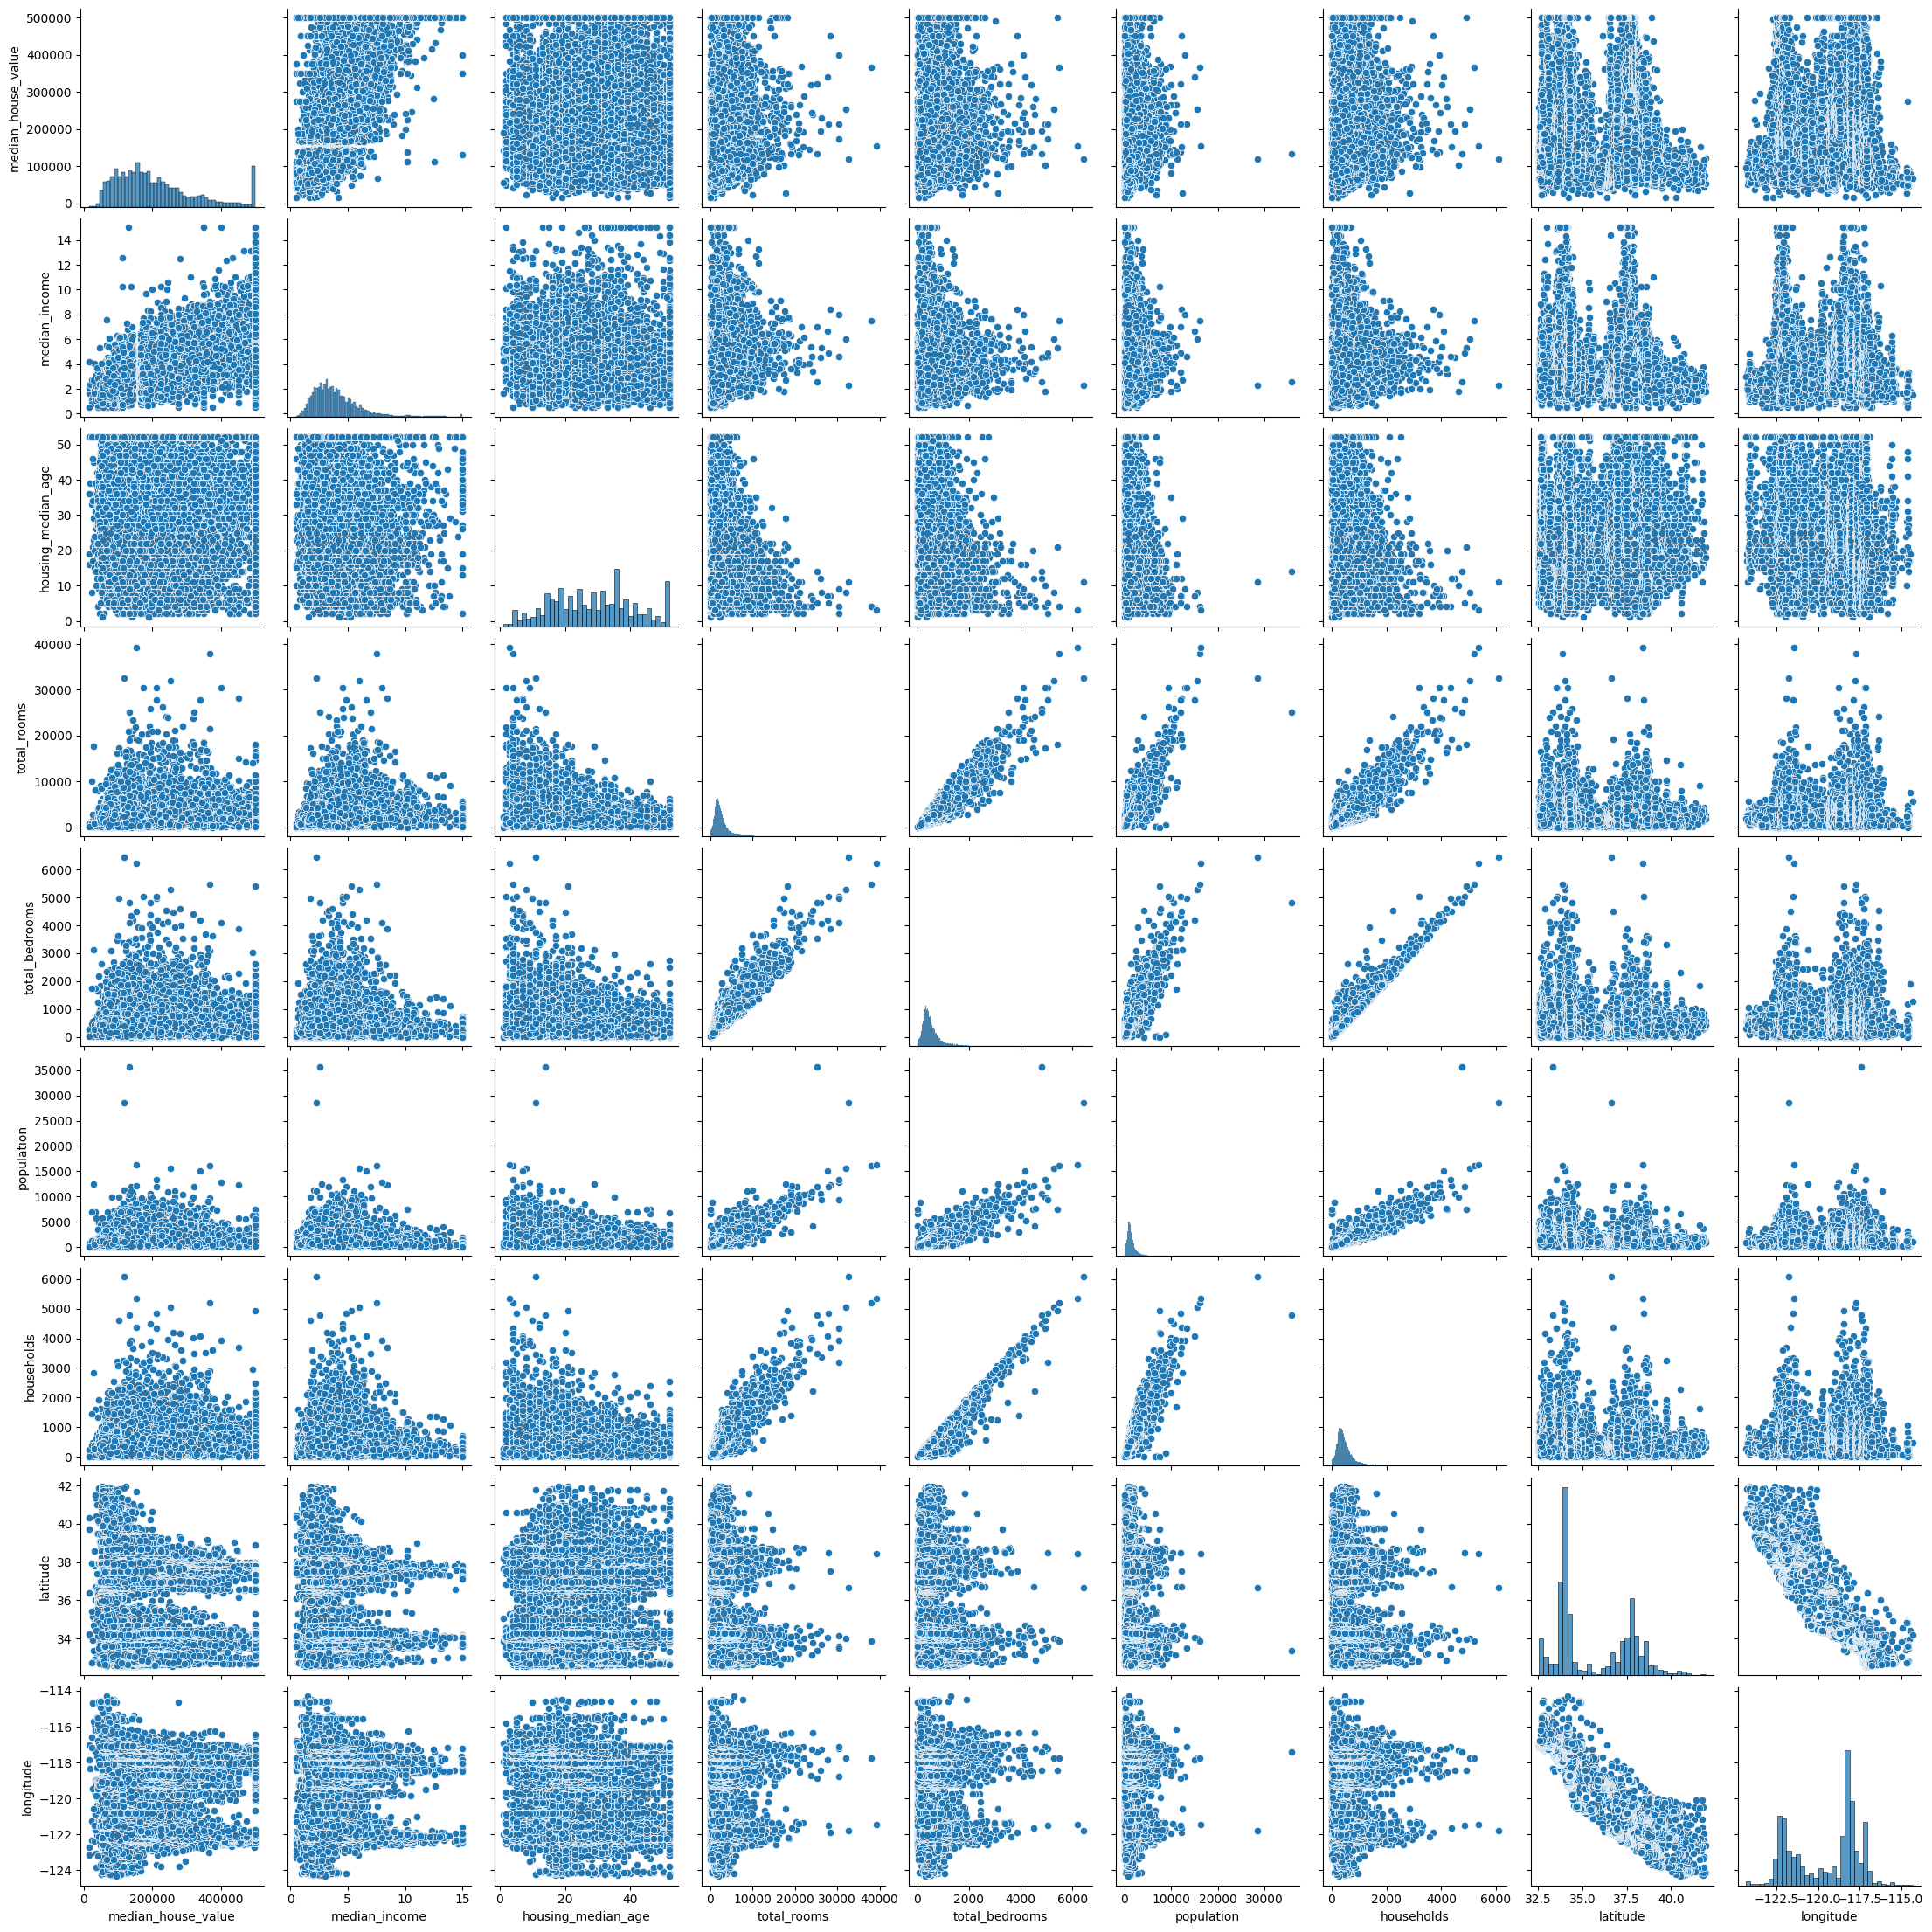

In [4]:
sns.pairplot(houses_corrupted)

Using the below code, I displayed a bar chart to visualise the non-missing data quickly to get a brief idea of which features to focus on. Instead of using the entire dataset and slowing the machine down, I opted to use the first 500 rows to provide an overview of the data and how much is missing. The height of each bar represents the number of non-missing values. If the bar is shorter or missing, it indicates missing data in that feature. Hence, median_income, housing_median_age, and population have missing values.

<Axes: >

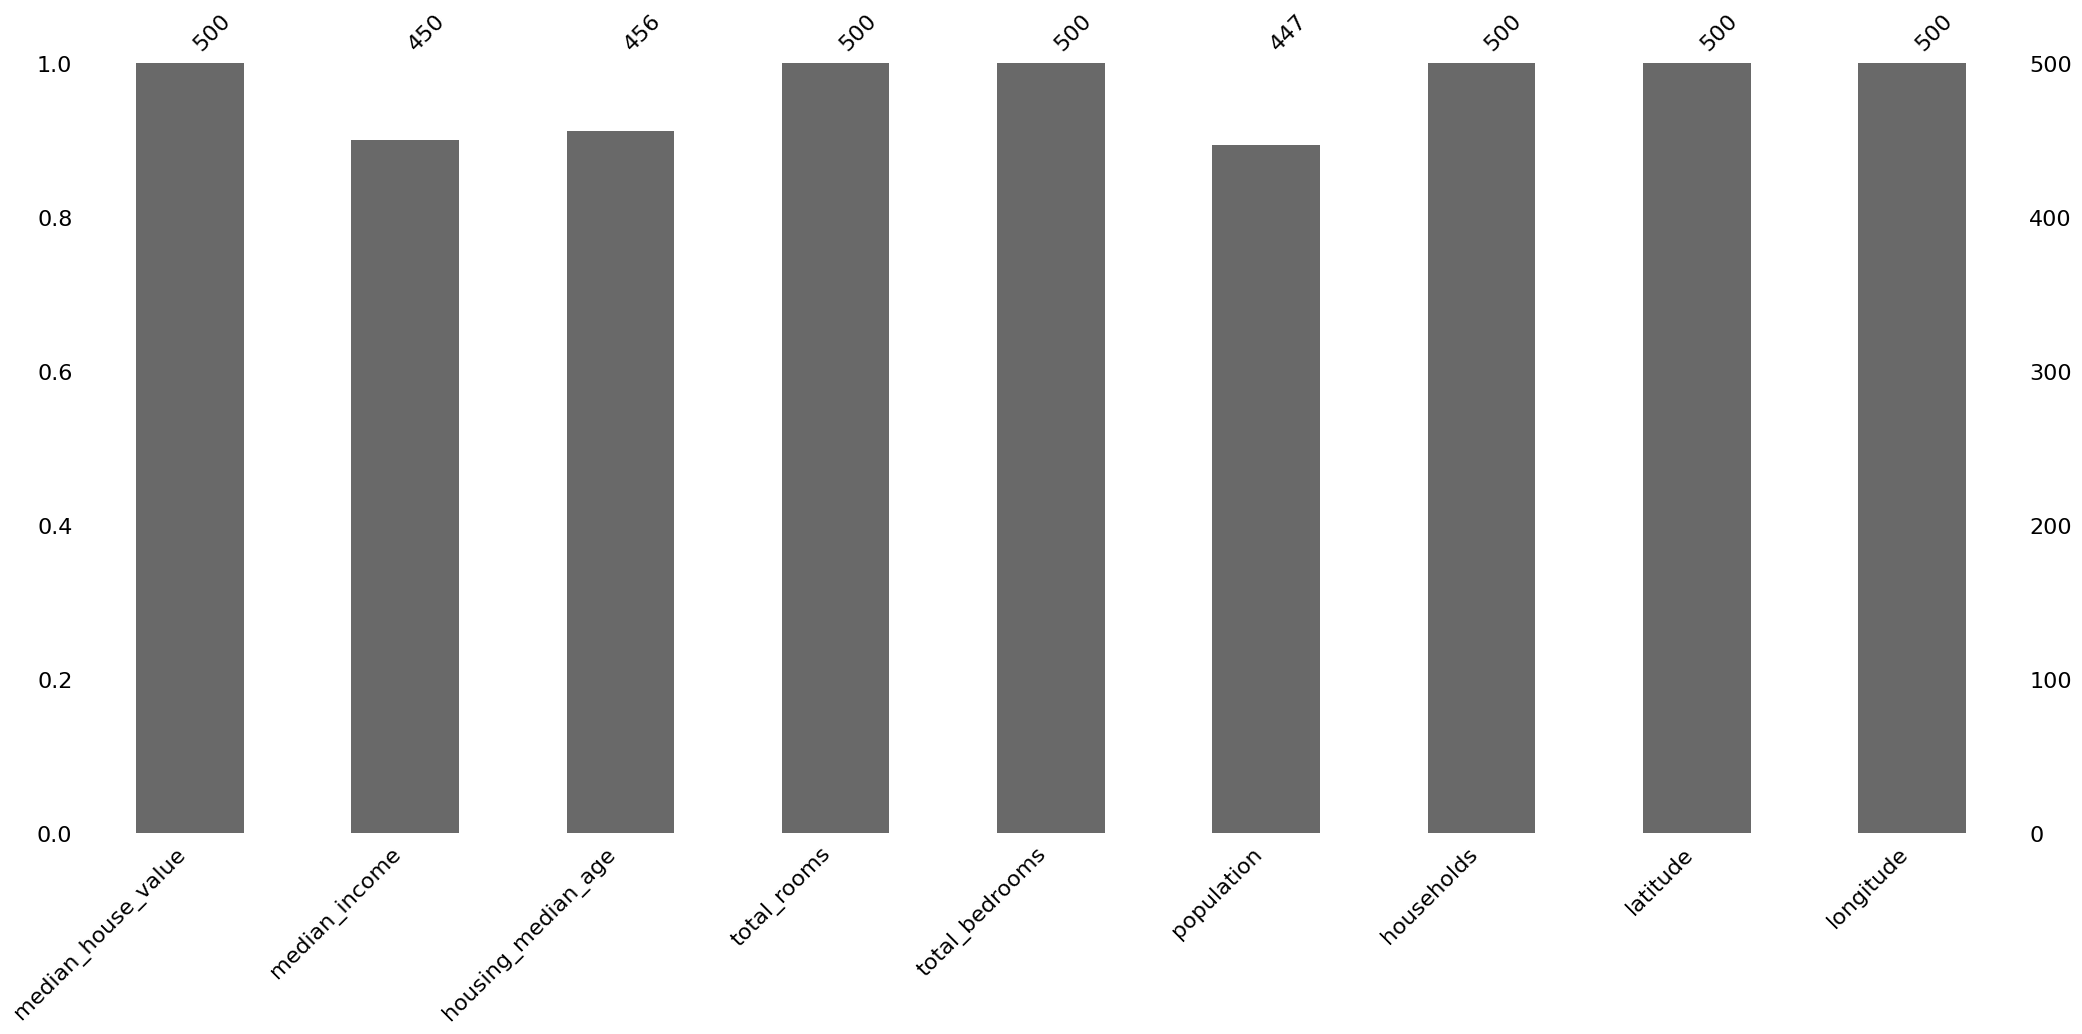

In [5]:
%matplotlib inline
msno.bar(df_orig.sample(500, random_state=32))

For further analysis, I printed the missing data from each column as a percentage of the entire column to highlight which values were missing.

In [6]:
missing_data = houses_corrupted.isnull().sum()
missing_percentage = (missing_data / len(houses_corrupted)) * 100
print(pd.DataFrame({"Missing Values": missing_data, "Percentage": missing_percentage}))

                    Missing Values  Percentage
median_house_value               0         0.0
median_income                 2064        10.0
housing_median_age            2064        10.0
total_rooms                      0         0.0
total_bedrooms                   0         0.0
population                    2064        10.0
households                       0         0.0
latitude                         0         0.0
longitude                        0         0.0


The generated heatmap below shows a visual summary of the missing data in the dataset. The rows (horizontal) correspond to individual observations in the dataset whereas the columns (vertical) respond to a feature variable in the dataset. The heat map indicates sporadic missing values across the different rows and are scattered. Additionally, there are few missing values, but they are distributed sparsely. There are no obvious patterns regarding the missing values.

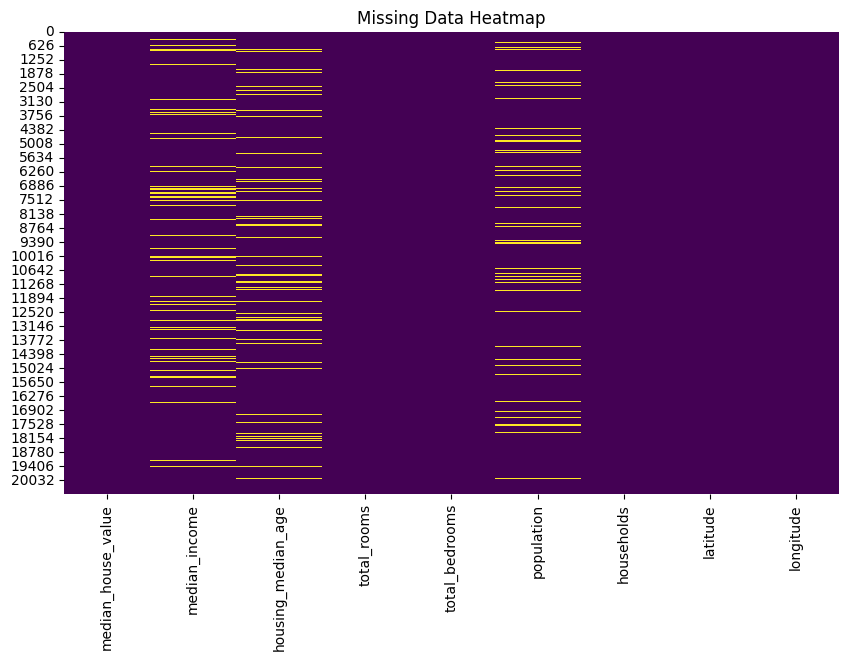

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(houses_corrupted.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

Overall, the key observations are that there are features with missingness more than other columns and some rows lack values for some attributes. This could skew the data analysis process. For housing_median_age and population the missingness appears to be at random as the missing values are somewhat evenly spread across without any sort of obvious pattern. However, population and median_income both have values that need to be investigated as the gaps are inconsistent thus making it a potential candidate for imputation. Upon initial observations and using the missing data percentage, it is visible that the percentage of missing data is sparse and should not be too difficult to handle as simple imputation my suffice. If the proportion of missing data was substantial then the performance would be affected if the data is left untreated.

### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


## Statistical Outlier Detection Approach
For the statistical outlier detection approach, I relied on IQR and Robust Z-score detection. This allowed me to directly compare the two outputs by printing the number of outliers detected by both. The IQR method created a subset of the data to identify how much of the data can be indentified as an outlier so that I could observe the skewed distributions more closely.

The Robust Z-score method relies on the mean and standard deviation which are sensitive to extreme outliers. This allowed the data to be resistant to the influence of extreme values and more accurately identify rows that deviate from the bulk of the data. The threshold of ±3 for Z-scores is chosen based on statistical convention and practicality. According to the empirical rule, 99.7% of data in a normal distribution lies within 3 standard deviations of the central tendency, making values beyond this range statistically rare. While the robust Z-score does not assume normality, the threshold of 3 remains effective for identifying extreme deviations in most datasets. It provides a balance between detecting meaningful anomalies and minimizing false positives. Furthermore, this threshold is widely accepted in the field of data analysis, ensuring consistency with established practices.

In [8]:
# Calculate Q1, Q3, and IQR for numerical columns
Q1 = houses_corrupted.quantile(0.25)
Q3 = houses_corrupted.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers in each column
outliers = (houses_corrupted < (Q1 - 1.5 * IQR)) | (houses_corrupted > (Q3 + 1.5 * IQR))

# Flag rows with any outlier
outlier_rows = outliers.any(axis=1)

# Count the number of outlier rows
num_outliers = outlier_rows.sum()

print(f"Number of outliers identified by IQR: {num_outliers}")

Number of outliers identified by IQR: 2911


In [9]:
def robust_z_score(series):
    median = series.median()
    mad = np.median(np.abs(series - median))
    return 0.6745 * (series - median) / mad

numeric_data = houses_corrupted.select_dtypes(include='number')
robust_z_scores = numeric_data.apply(robust_z_score)

# Flag rows as outliers if any Z-score exceeds the threshold
threshold = 3
outliers_robust_zscore = (robust_z_scores.abs() > threshold).any(axis=1)
data_outliers_z = houses_corrupted[outliers_robust_zscore]
print(f"Number of outliers using Robust Z-score: {data_outliers_z.shape[0]}")

Number of outliers using Robust Z-score: 3118


## **Feature-Wise Observations**

### 1.   Median House Value
The boxplot has a well defined IQR with significant outliers in the upper range. The median house value is within a reasonable range, but the extreme high values represent outliers which are likely to be high-end properties/homes. The violin plot shows skewed distribution, with majority of the values clustered at the lower end and the broader distribution at the top reflects the presence of higher house values.
### 2.   Median Income
The boxplot indicates that the IQR is narrow and thus most households have a similar income level. There are some outliers present which indicate higher income households. The violin plot suggests two distinct income brackets in the population whereas majority has lower income levels.
### 3. Housing Median Age
The distribution of the housing age shows minimal outliers. Most of the houses fall within a balanced range of ages, centered around the median. The violin plot shows symmetrical and uniform distribution for this feature indicating that the housing ages are evenly distributed.
### 4. Total Rooms & Total Bedrooms
The boxplot reveals a narrow IQR but a substantial amount of extreme outliers on the upper end for both. Most houses have a typical range of rooms, whilst some exhibit significantly higher room counts (that could be because of large buildings or developments). The distributions are positively skewed with a long tail.
### 5. Population & Households
The population data has a significant number of extreme outliers, likely corresponding to urban areas or dense communities. The majority of the population sizes fall within a tightly packed IQR. The violin plot has a sharp peak that is visible at lower population sizes, followed by a long tail that extends towards high-density areas. This indicates that majority of the areas have a smaller population with some that are extremely populous.

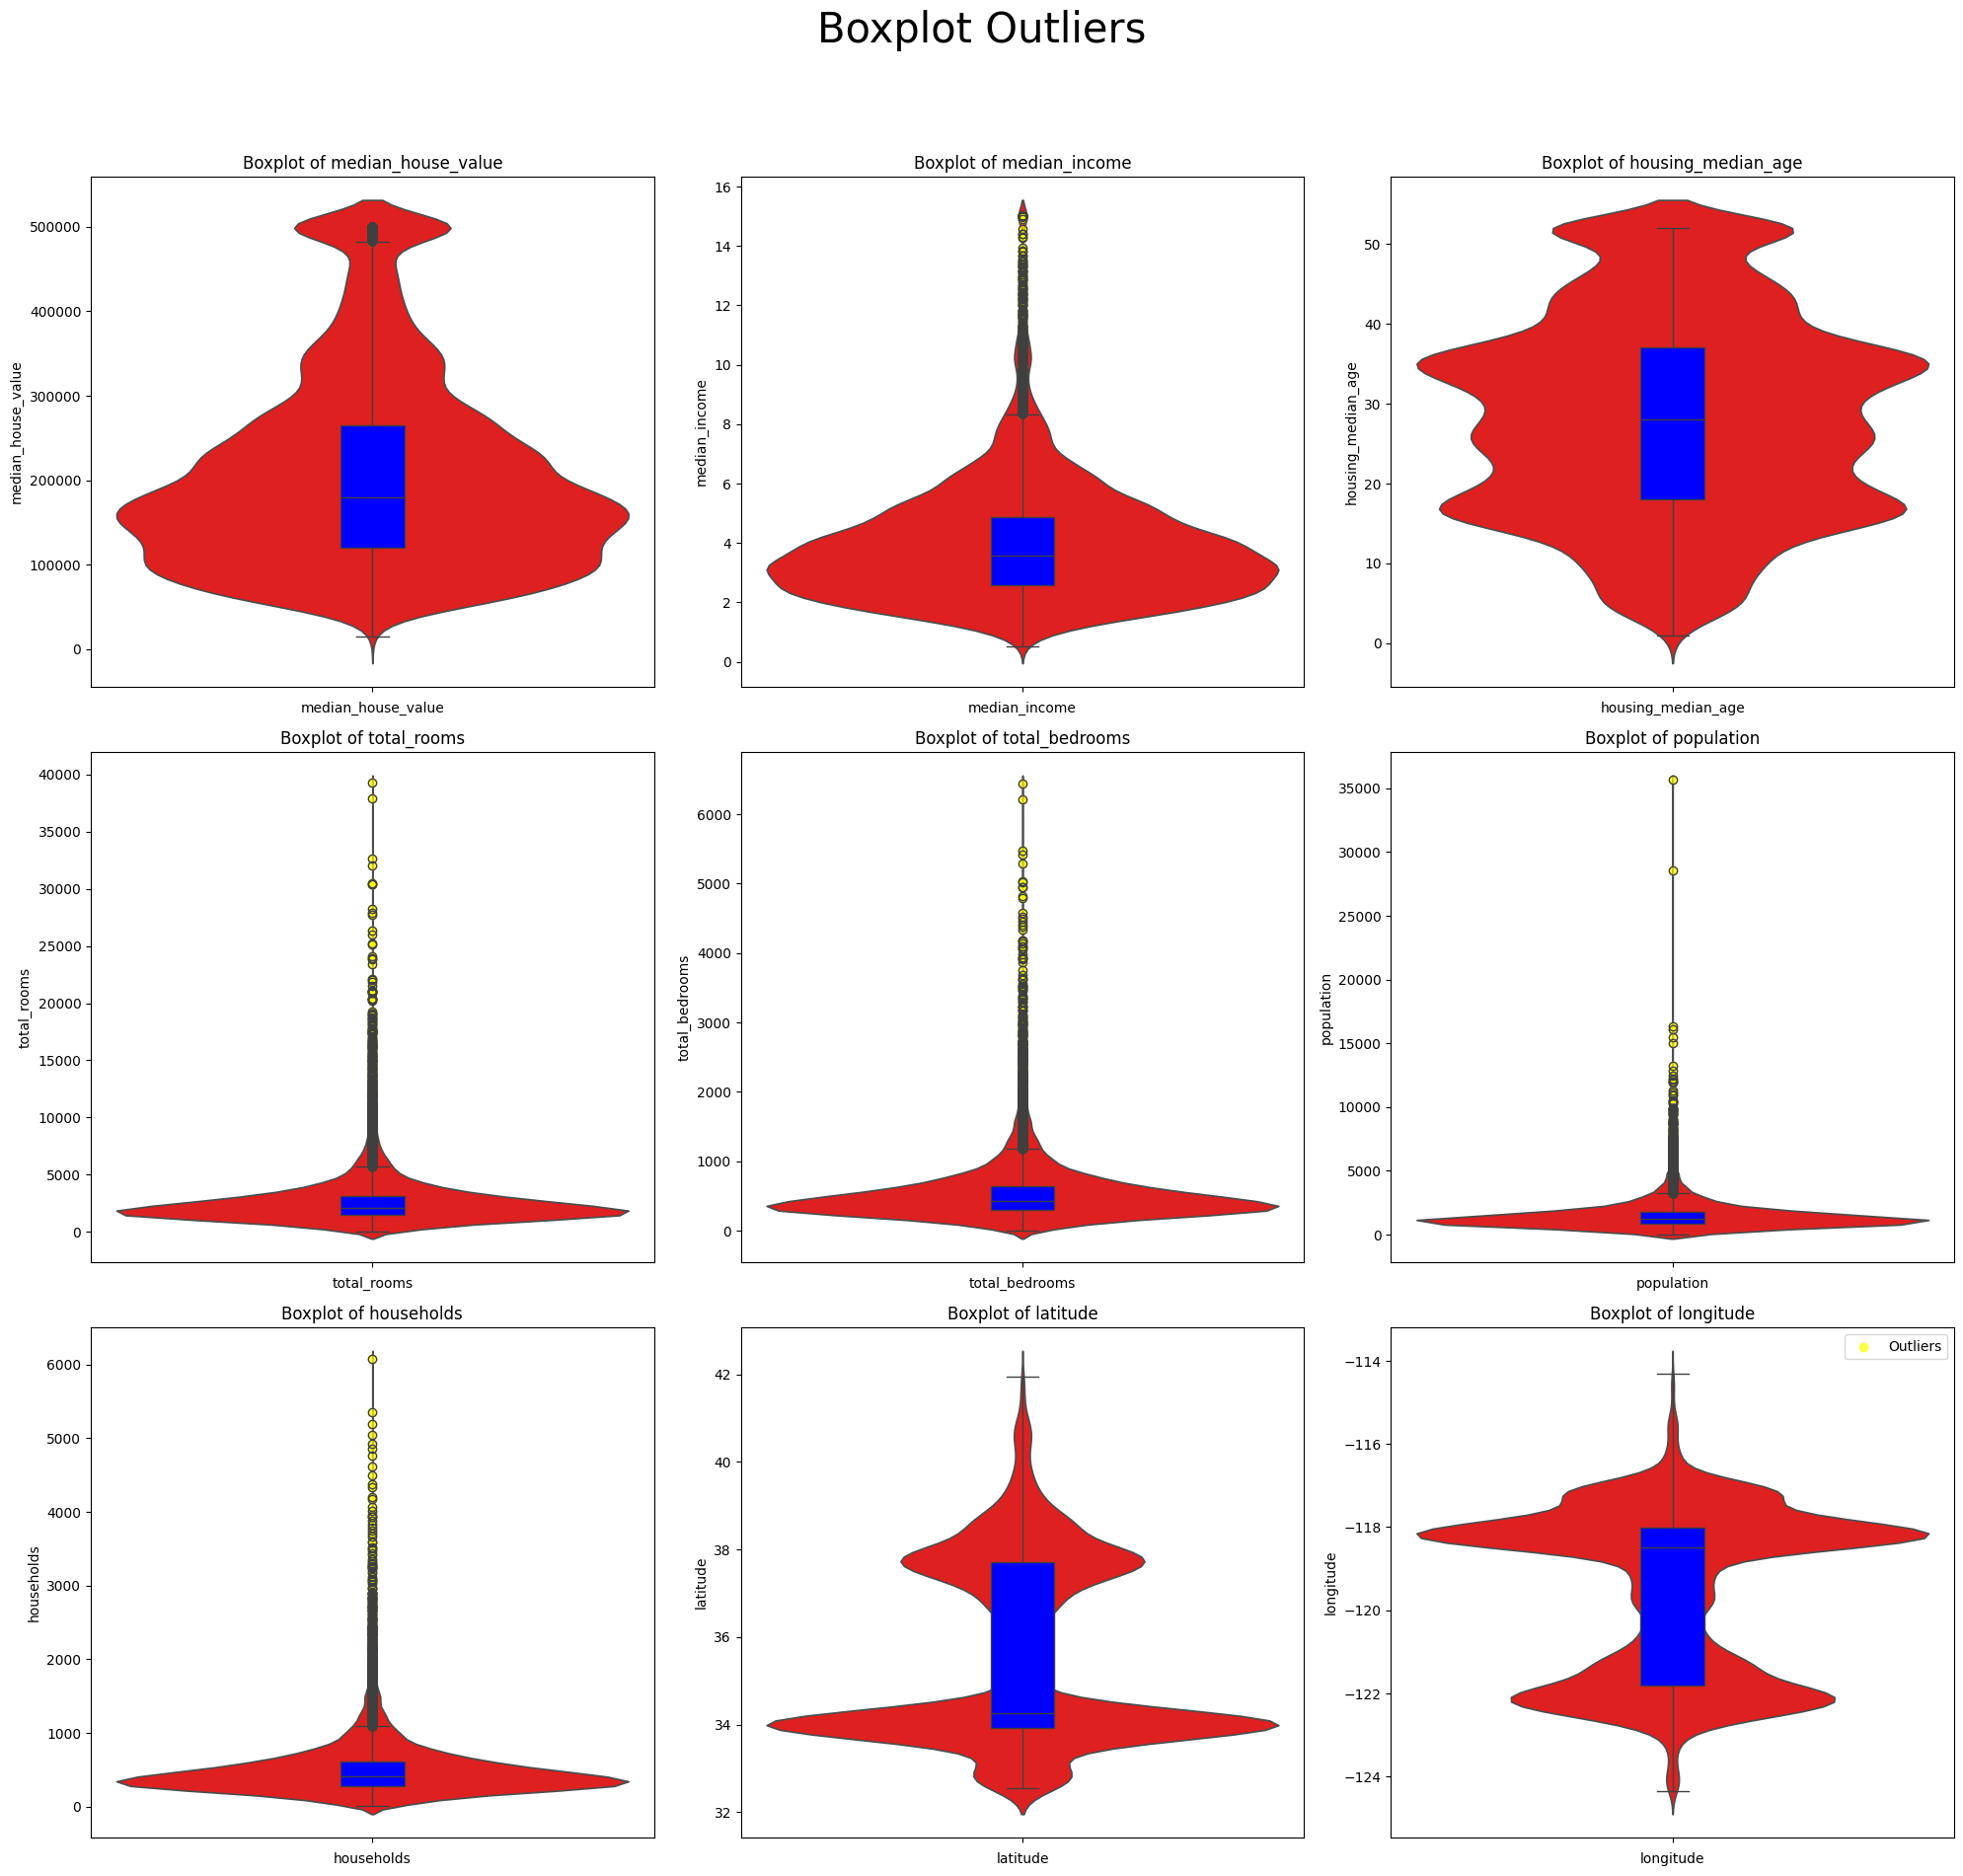

In [10]:
# Identify outliers for each feature
outliers = {}
for feature in houses_corrupted.columns:
    q1 = houses_corrupted[feature].quantile(0.25)
    q3 = houses_corrupted[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers[feature] = houses_corrupted[(houses_corrupted[feature] < lower_bound) |
                                         (houses_corrupted[feature] > upper_bound)][feature]

plt.figure(figsize=(20, 25))
plt.suptitle('Boxplot Outliers', fontsize=30)

for i, feature in enumerate(df_orig.columns, 1):
    plt.subplot((len(houses_corrupted.columns) // 3) + 1, 3, i)
    sns.violinplot(y=houses_corrupted[feature], inner=None, color='red')
    sns.boxplot(y=houses_corrupted[feature], width=0.1, boxprops = {"facecolor":'blue'}),
    #flierprops=dict(marker='o', markerfacecolor='red', markersize=3, markeredgecolor='red')
    # Highlight outliers
    plt.scatter(
        y=outliers[feature],
        x=[0] * len(outliers[feature]),
        color='yellow',
        label='Outliers',
        alpha=0.7
    )
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout(rect=[0,0,1,0.95])
plt.legend()
plt.show()

To represent the statistical data, I generated a grid of subplots with each showing a violin plot overlaid by a boxplot of a given feature from the original dataset. The plots explicitly visualise the outliers by marking ad highlighting them. The violin plot displays how the data is distributed and the boxplot shows the summary statistics by means of median, quartiles, and outliers. The outliers are identified using the IQR and they are highlighted in yellow dots on the plots, making them easily distinguishable from the rest of the data. Additionally, by viewing these plots side by side, it is easier to identify which features have a higher presence of outliers and thus analyse the distribution and spread across the different features.

## Algorithmic Outlier Detection Approach
For the algorithmic approach, I opted to use Isolation Forest. Using this algorithm allowed me to identify outliers programmatically across the features.

In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay

# Prepare data by removing non-numerical features
numeric_data = houses_corrupted.select_dtypes(include='number').dropna()

# Train Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.05)
outlier_predictions = iso_forest.fit_predict(numeric_data)

# -1 indicates outliers
data_outliers_algo = numeric_data[outlier_predictions == -1]
print(f"Number of outliers using Isolation Forest: {data_outliers_algo.shape[0]}")

Number of outliers using Isolation Forest: 753


### Comparison of Algorithmic and Visualisation-Based Outlier Detection

Using the two approaches, I was able to identify outliers in the housing dataset.

### 1. Visualisation Approach
The boxplot component helps pinpoint outliers in the individual features by showing data points beyond the whiskers. The violin plots enhance this by revealing the underlying distribution of the data, including multimodality and skewness. The visual approach allows users to intuitively understand the distribution of each feature and thus make it easier to identify patterns and anomalies. For example, median_house_value showed clear outliers in the higher value range. However, the limitations of this approach include its time-consuming nature and lack of context across the features. Analyzing these features individually requires considerable effort, additionally, this approach considers outliers within a single feature at a time and ignores potential relationships between the features.

### 2. Algorithmic Approach
Unlike the visualisation approach, the Isolation Forest considers the relationships between multiple features simulataneously. For instance, the data point with slightly anomalous values in multiple features may collectively appear as an outlier, even if it doesn't stand out in a single feature. The algorithm operates programmatically, making it efficient and scalable to larger datasets such as this one. However, the limitations of this method include its immediate lack of interpretability as compared to visual methods. It is not always clear how a particular point is flagged as an outlier without any further analysis.

### Conclusion
For this dataset, the visualisation method identifies significant outliers in the features such as median_house_value, total_rooms, and population. This provides clear insights into the distributions. The algorithmic method flagged 753 outliers whilst considering all numerical features which potentially reveals some subtle anomalies across multiple dimensions.

In [13]:
houses_with_outliers = houses_corrupted.copy()
houses_without_outliers = houses_corrupted[~outliers_robust_zscore]

I created a copy of the houses_corrupted dataset with no outliers present and another with outliers.

### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [22]:
# Use this dataset for comparison against the imputed datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

In [14]:
# Check missing values percentage
missing_percent = df_orig.isnull().mean() * 100
print("Missing Percentage:\n", missing_percent)

# Define threshold for removing features with too many missing values
threshold = 30  # Features with more than 30% missing will be removed

# Identify features for imputation and removal
features_to_impute = missing_percent[missing_percent <= threshold].index.tolist()
features_to_remove = missing_percent[missing_percent > threshold].index.tolist()

print(f"Features to impute: {features_to_impute}")
print(f"Features to remove: {features_to_remove}")

# Drop features with excessive missing data
houses_imputable = df_orig.drop(columns=features_to_remove)


Missing Percentage:
 median_house_value     0.0
median_income         10.0
housing_median_age    10.0
total_rooms            0.0
total_bedrooms         0.0
population            10.0
households             0.0
latitude               0.0
longitude              0.0
dtype: float64
Features to impute: ['median_house_value', 'median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude', 'longitude']
Features to remove: []


For initial imputation, the Isolation Forest algorithm was applied to detect the anomalies in the housing dataset, using both the subset of the features for visualisation and the full numerical dataset. Before applying the Isolation Forest, the missing values were imputed using SimpleImputer with a mean strategy. This ensures that the dataset is complete and suitable for analysis because Isolation Forest cannot handle missing values. For the visualisation, I selected two key features - median_house_value and median_income. The Isolation Forest was then applied to all the features and I set the contamination parameter to 0.05, assuming that 5% of the data points are anomalies. The outliers were extracted into a seperate dataset for further analysis.

The key features of the visualisation include:
*   Yellow points: These represent the inliers, the data points classified as part of the typical distribution. These form a cluster representing typical housing prices corresponding to the median income values.
*   Purple points: Represent the outliers, the data points deemed anomalous by the algorithm. The houses with extremely high values or low incomes are classed here.
*   Decision Boundary: The background color reflects the algorithm's classification regions. Areas with different shades indicate varying confidence levels of outlier and inlier detection.

This visualisation confirms the effectiveness of Isolation Forest in identifying the anomalies in the housing dataset. The algorithm detected 1032 outliers across all of the numerical features, with the decision boundary providing an intuitive understanding of outlier classification for the two chosen features. Now the outliers can be imputed using KNN and MICE Imputation.

For ease of differentiation, I created two separate datasets; inliers_data contains all the rows flagged as inliers, and outliers_data contains all the rows flagged as outliers. Saving them to a .csv format allows me to analyse them further.

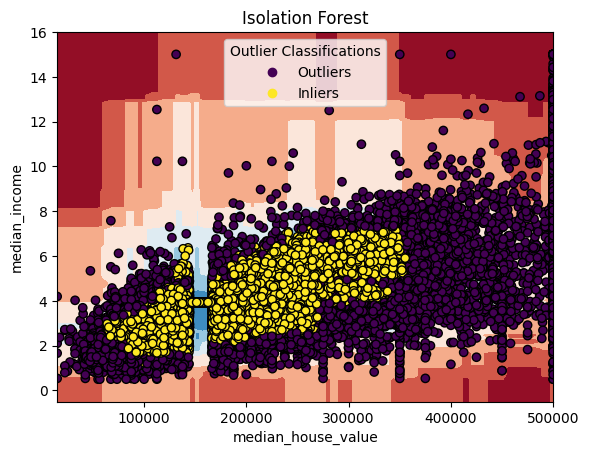

Inliers data shape: (19608, 9)
Outliers data shape: (1032, 9)
Number of outliers using Isolation Forest: 1032


In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.impute import SimpleImputer

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Can choose other strategies like 'median'
df_orig_imputed = imputer.fit_transform(df_orig)

# Convert the imputed array back to a DataFrame
# to maintain column names and structure
df_orig_imputed = pd.DataFrame(df_orig_imputed, columns=df_orig.columns)

# Select only two features for visualization
X_for_viz = df_orig_imputed[['median_house_value', 'median_income']]  # Choosing two features

clf = IsolationForest(n_estimators=10, max_samples=100)
y_pred = clf.fit_predict(X_for_viz) # use the imputed data

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_for_viz, # use the imputed data
    response_method="decision_function",
    cmap=plt.cm.RdBu
)
scatter = disp.ax_.scatter(X_for_viz['median_house_value'], X_for_viz['median_income'], c=y_pred, edgecolor="k")
disp.ax_.set_title("Isolation Forest")
handles, lables  = scatter.legend_elements()
plt.legend(handles = handles, labels = ["Outliers", "Inliers"], title="Outlier Classifications")
plt.show()

# Prepare data by removing non-numerical features
# The SimpleImputer already handled missing values, can skip dropna() here
numeric_data = df_orig_imputed.select_dtypes(include='number') # use the imputed data

# Train Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.05)
outlier_predictions = iso_forest.fit_predict(numeric_data)

# Adding the predictions to the original dataset
houses_corrupted['Outlier'] = outlier_predictions

# Create copies of the dataset
# Inliers only
inliers_data = houses_corrupted[houses_corrupted['Outlier'] == 1].drop(columns=['Outlier'])

# Outliers only
outliers_data = houses_corrupted[houses_corrupted['Outlier'] == -1].drop(columns=['Outlier'])

# Save the inliers and outliers as separate datasets
inliers_data.to_csv("houses_inliers.csv", index=False)
outliers_data.to_csv("houses_outliers.csv", index=False)

# Confirm datasets
print(f"Inliers data shape: {inliers_data.shape}")
print(f"Outliers data shape: {outliers_data.shape}")
# -1 indicates outliers
data_outliers_algo = numeric_data[outlier_predictions == -1]
print(f"Number of outliers using Isolation Forest: {data_outliers_algo.shape[0]}")

# KNN Imputation
Using KNN Imputation, I handled the missing values in the houses_corrupted dataset as they were present in various features of this dataset. For this method, only numerical features are required so it suited the dataset well. The missing values were imputed using the KNNImputer class and using the average of the 5 nearest neighbours. I chose 5 as it is commonly used as an average and and using far to few neighbours would have made the imputation highly sensitive, thus 5 provides a balanced approach for the overall data structure. After imputation, the imputed dataset was saved as a csv file for further analysis.

The results of KNN Imputation retains the original structure and size of the dataset whilst successfully replacing the missing values. To ensure this, I printed the houses_imputed_view.isnull().sum() to confirm that the missing values were imputed.

In [16]:
from sklearn.impute import KNNImputer

# Create a KNN Imputer instance
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Select only numeric columns for KNN imputation
numeric_data = houses_corrupted.select_dtypes(include=['float64', 'int64'])

# Apply KNN imputation
numeric_data_imputed = knn_imputer.fit_transform(numeric_data)

# Convert the imputed array back to a DataFrame to preserve column names
numeric_data_imputed = pd.DataFrame(numeric_data_imputed, columns=numeric_data.columns)

# Replace the imputed data in the original dataset
houses_imputed_KNN = houses_corrupted.copy()
houses_imputed_KNN[numeric_data.columns] = numeric_data_imputed

# Save the imputed dataset to a CSV file
houses_imputed_KNN.to_csv("houses_knn_imputed.csv", index=False)

In [17]:
# Load the saved CSV file
houses_imputed_KNN_view = pd.read_csv("houses_knn_imputed.csv")

# Display the first few rows of the dataset
print(houses_imputed_KNN_view.head())

   median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   

   total_bedrooms  population  households  latitude  longitude  Outlier  
0           129.0       322.0       126.0     37.88    -122.23      1.0  
1          1106.0      2401.0      1138.0     37.86    -122.22      1.0  
2           190.0       678.2       177.0     37.85    -122.24      1.0  
3           235.0       537.0       219.0     37.85    -122.25      1.0  
4           280.0       565.0       259.0     37.85    -122.25      1.0  


Here I decided to test different n_neighbour values

In [18]:
# Test different n_neighbors values
for k in [3, 5, 7, 10]:
    knn_imputer = KNNImputer(n_neighbors=k)
    imputed_data = knn_imputer.fit_transform(houses_corrupted)
    print(f"n_neighbors={k}: Imputation completed")
    # Evaluate or visualize the results for each k

n_neighbors=3: Imputation completed
n_neighbors=5: Imputation completed
n_neighbors=7: Imputation completed
n_neighbors=10: Imputation completed


In [ ]:
print(houses_imputed_KNN_view.isnull().sum())

median_house_value    0
median_income         0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
latitude              0
longitude             0
Outlier               0
dtype: int64


# MICE Imputation
The goal was to impute missing values using MICE Imputation which was implemented through IterativeImputer in Scikit-learn. Initially, the housing dataset was inspected for missing values which I then commented out as it was a simple precautionary step. The IterativeImputer was initialised with random_state=42 as this ensured consistent imputation results across runs. Additionally, max_iter=10 allows the iteration process to refine estimates of missing values up to 10 iterations. These parameters ultimately provide a balance between computational efficiency and accuracy. The IterativeImputer imputes the missing values by modelling each feature as a function of all the other features in the dataset by each iteration cycling through features with missing values. These missing values are then imputed with a simple mean in the initial stages and then iteratively updated by modelling their relationships with the other features. Ultimately, the result was stored in a dataframe to maintain column names and facilitate integration with the original dataset.

The imputed dataset no longer contains any missing values across its features and the iterative nature of MICE ensures that the imputed values are consistent with the relationships between features. However, when visualised, some imputed features showed slight misalignment with their original features. This could have occured due to weak correlations between the imputed feature and the others.

In conclusion, MICE Imputation successfully handled the missing values in the houses_corrupted dataset by using the multivariate relationships and through iterative refinement. While this is computationally intensive, the method overall provides robust imputations that preserve feature relationships and making the dataset ready for further analysis.

In [19]:
from sklearn.experimental import enable_iterative_imputer  # Needed to enable IterativeImputer
from sklearn.impute import IterativeImputer

# print(houses_corrupted.isnull().sum()) to check for presence of missing values in original dataset

# Initialize the Iterative Imputer (MICE)
mice_imputer = IterativeImputer(random_state=42, max_iter=10)  # max_iter can be adjusted

# Select numeric columns for imputation
numeric_columns = houses_corrupted.select_dtypes(include=['float64', 'int64']).columns
houses_numeric = houses_corrupted[numeric_columns]

# Apply MICE imputation
houses_imputed_mice = pd.DataFrame(
    mice_imputer.fit_transform(houses_numeric),
    columns=numeric_columns
)

# Replace the imputed numeric data back into the original dataset
houses_corrupted_imputed_MICE = houses_corrupted.copy()
houses_corrupted_imputed_MICE[numeric_columns] = houses_imputed_mice

# Verify imputation
print(houses_corrupted_imputed_MICE.isnull().sum())

median_house_value    0
median_income         0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
latitude              0
longitude             0
Outlier               0
dtype: int64


In [20]:
houses_corrupted_imputed_MICE.to_csv("houses_mice_imputed.csv", index=False)

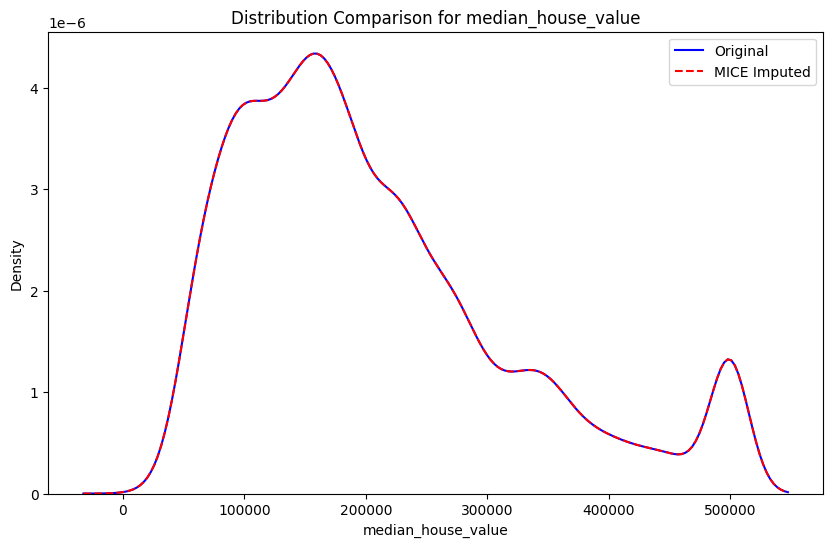

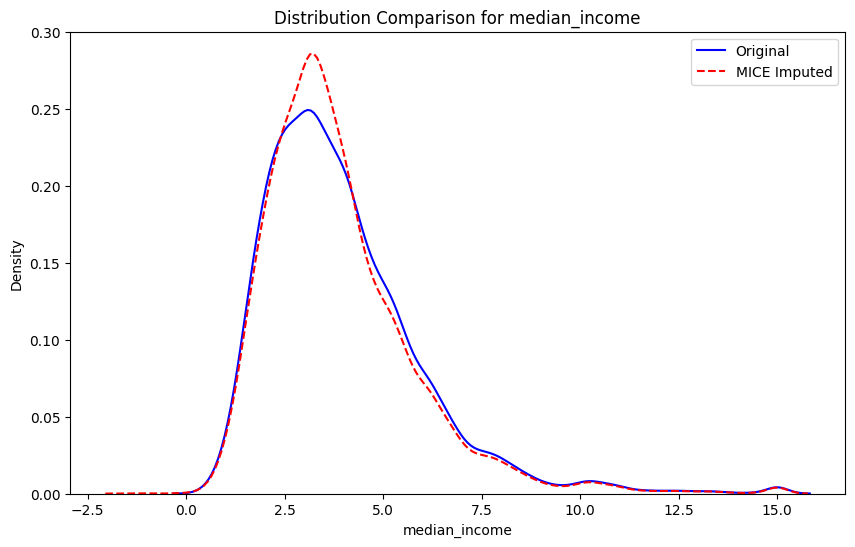

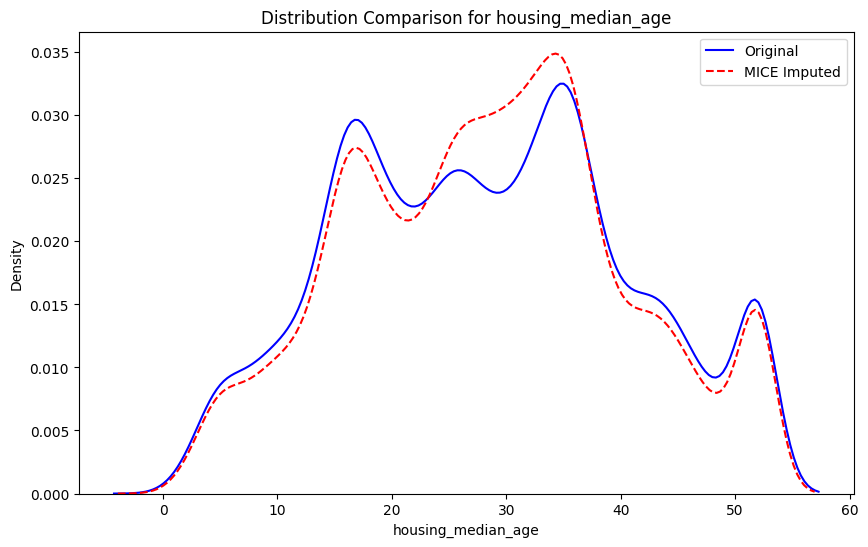

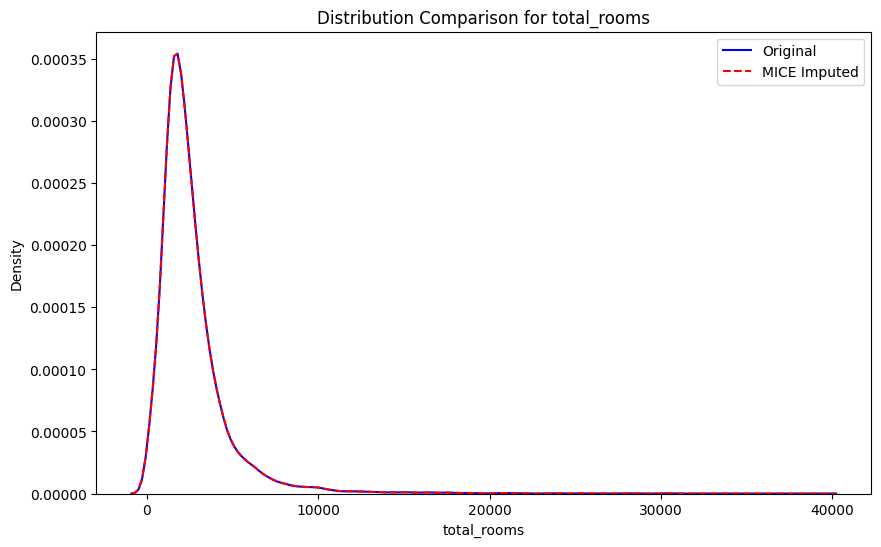

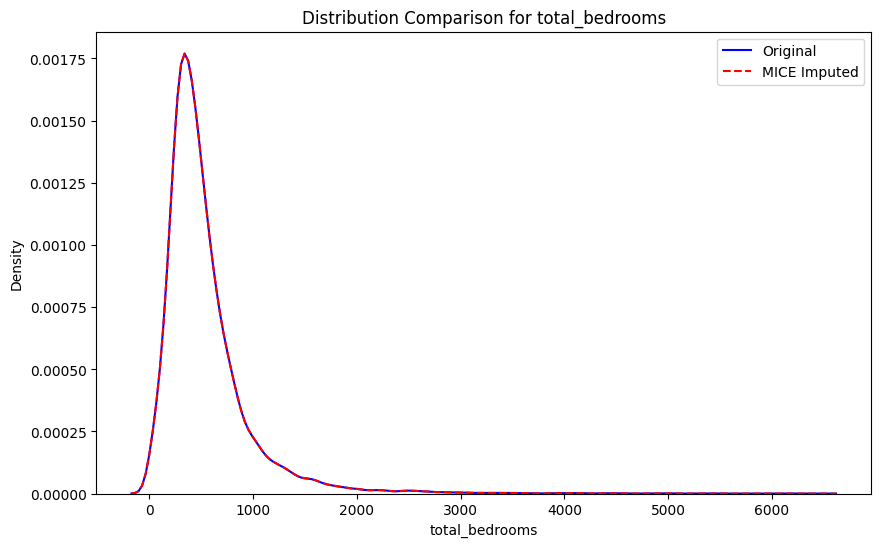

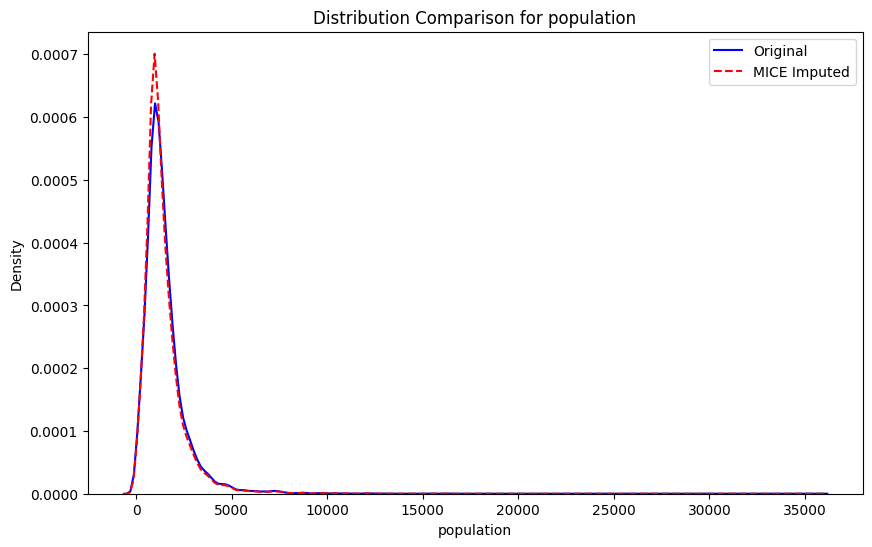

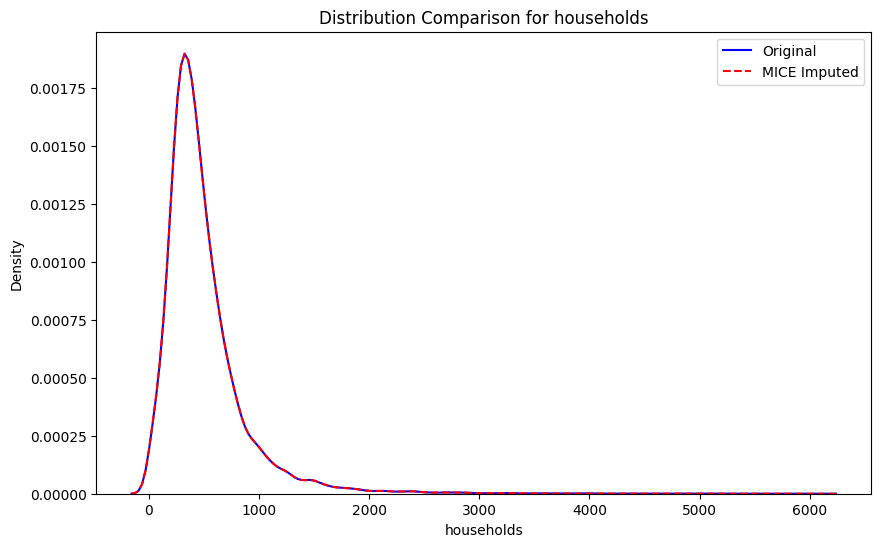

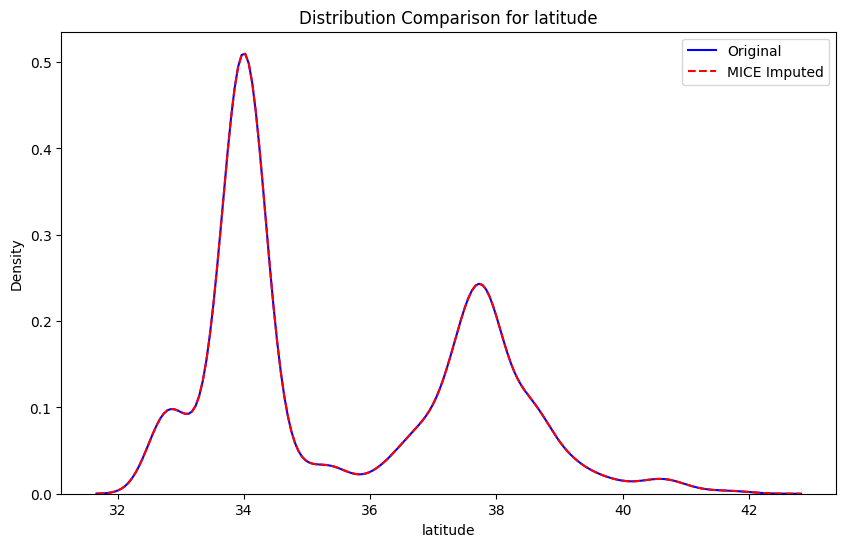

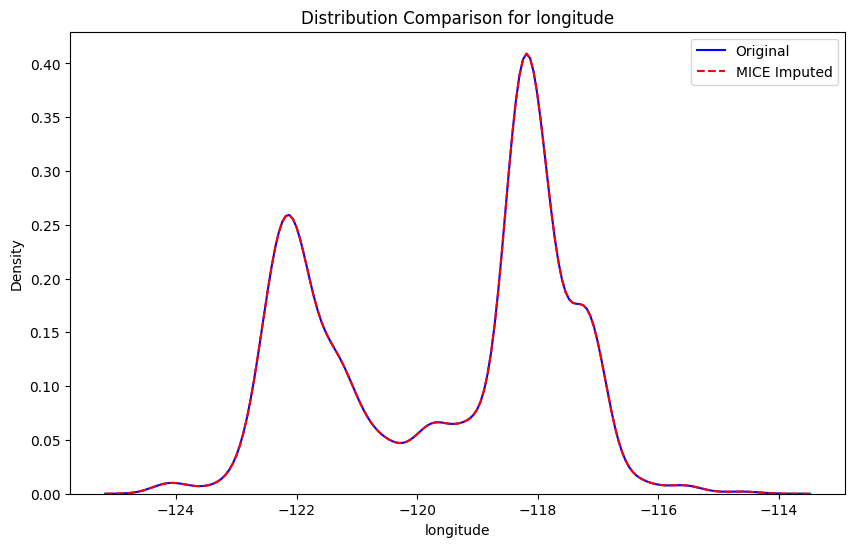

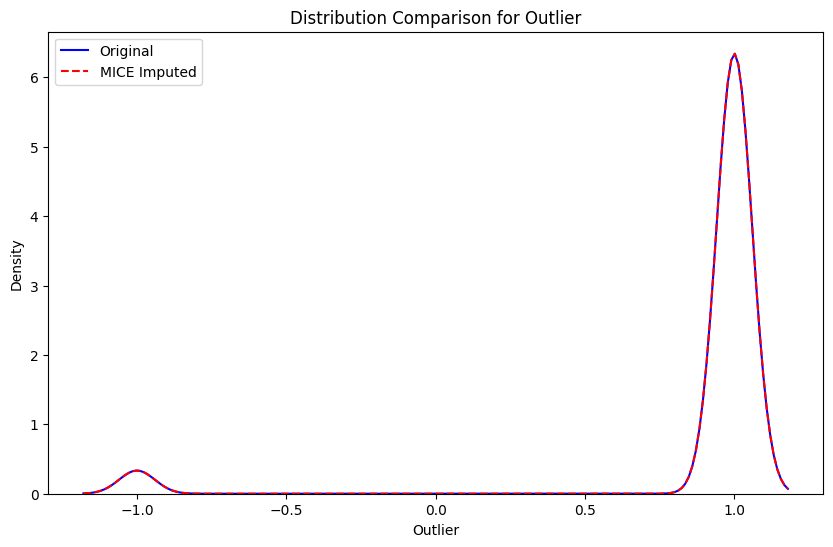

In [21]:
for feature in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(houses_numeric[feature], label="Original", color="blue")
    sns.kdeplot(houses_corrupted_imputed_MICE[feature], label="MICE Imputed", linestyle="--", color="red")
    plt.title(f"Distribution Comparison for {feature}")
    plt.legend()
    plt.show()

## Comparison of KNN and MICE Imputation with respect to the non-imputed dataset
This comparison will evaluate the ability of the two imputation techniques to handle the missing values while preserving the overall structure and the relationships within the data.

### Overview
*   Non-Imputed Dataset (houses):
This dataset represents the original dataset with no missing values and serves as base for assessing the quality of imputations.
*   KNN-Imputed Dataset (houses_knn_imputed):
This dataset had its missing values imputed by using the mean of the 5 nearest neighbours based on their feature similarity.
*   MICE-Imputed Dataset (houses_mice_imputed):
This dataset had its missing values imputed iteratively by modelling each feature as a function of all the others, refining the imputations over multiple iterations.

### Visualisation
The distribution charts below show how closely the imputed datasets align with the nonimputed original dataset's feature distributions. The misalignments or clustering show the limitations of the imputation methods.

### Results
The KNN-imputed dataset preserved the general shape of the feature distributions for most of the features and the imputed values aligned well with the ranges of the non-missing data. However, for features with high missing percentages, imputed values tended to cluster around the mean of nearby neighbors, reducing variability. The MICE-Imputed dataset's values aligned more closely with the original data and it captured the relationships better due to its imputation strategy across multivariant features. However, this is more computationally expensive as compared to KNN. To compare the two imputation techniques in terms of accuracy and efficiency, KNN is faster but it sacrifices some accuracy when capturing relationships, MICE is more extensive computationally but had better imputation quality.



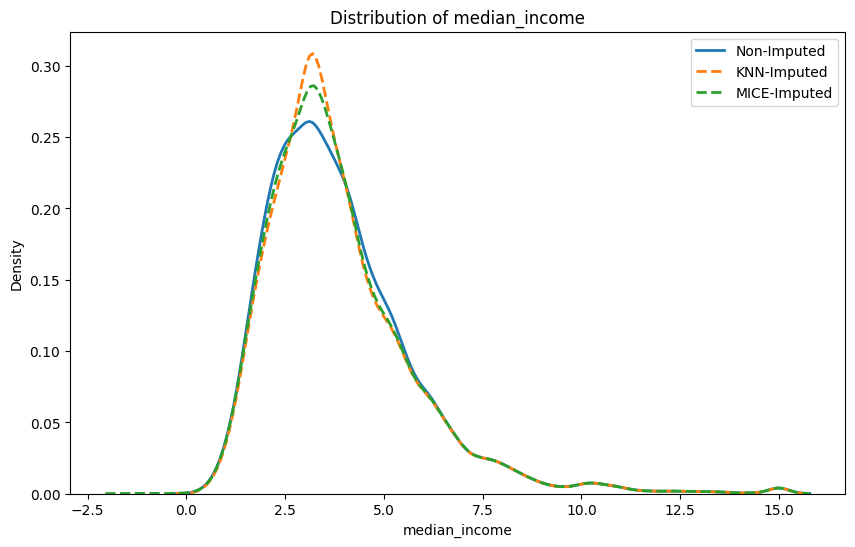

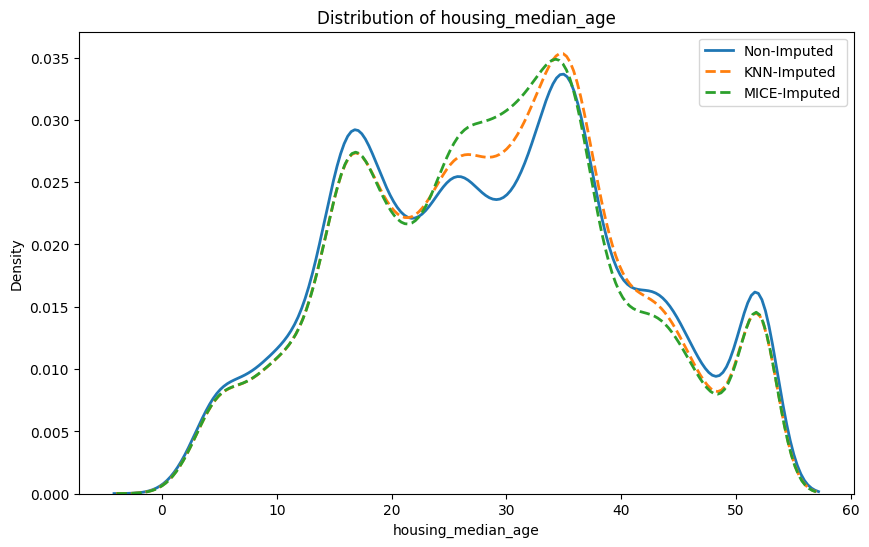

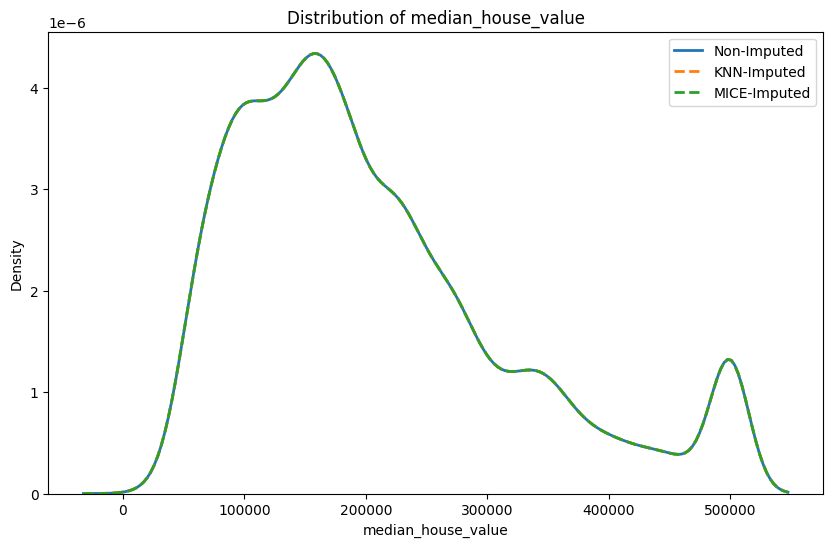

In [24]:
# Datasets for comparison
datasets = {
    "Non-Imputed": houses,
    "KNN-Imputed": houses_imputed_KNN_view,
    "MICE-Imputed": houses_corrupted_imputed_MICE
}

# Features to compare
features_to_plot = ['median_income', 'housing_median_age', 'median_house_value']

# Generate KDE plots
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    for label, dataset in datasets.items():
        sns.kdeplot(dataset[feature], label=label, linestyle="--" if label != "Non-Imputed" else "-", linewidth=2)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

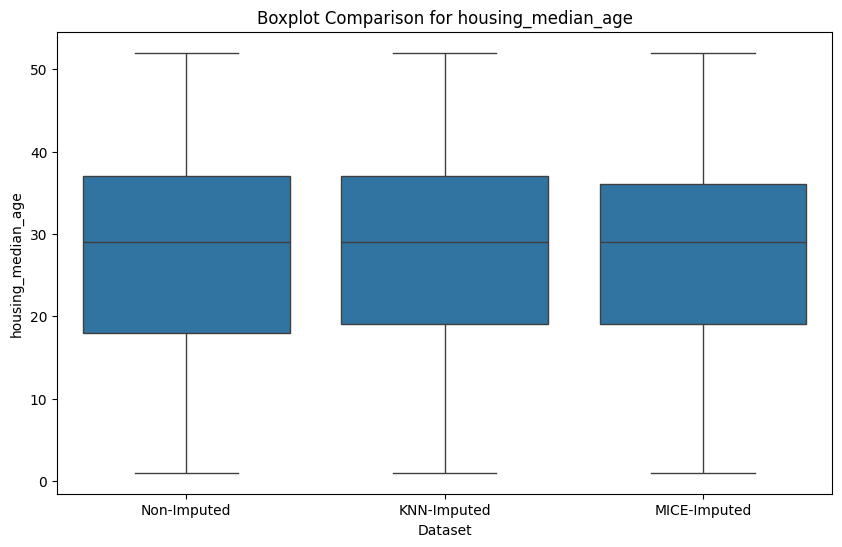

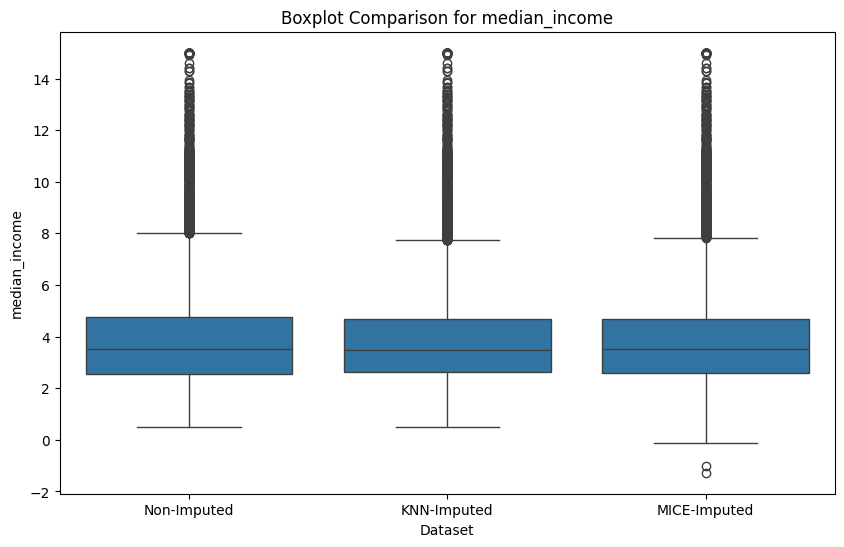

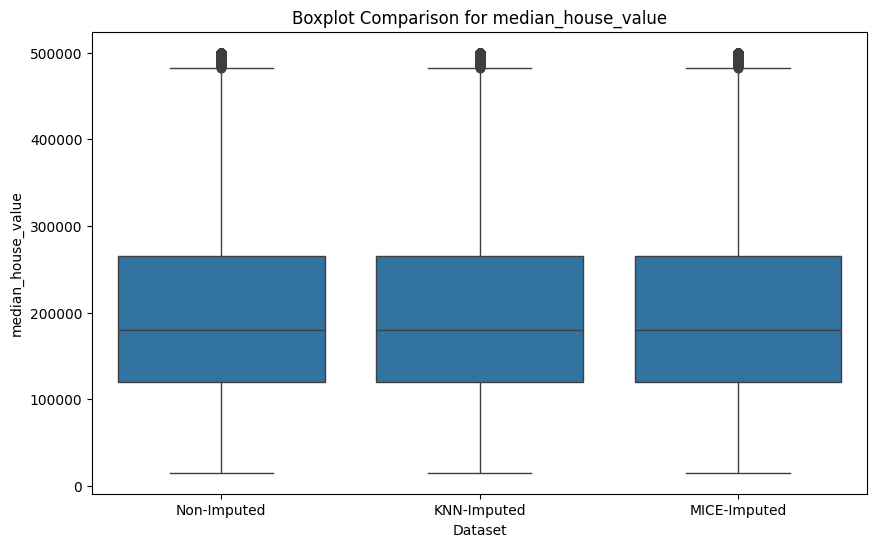

In [27]:
# Combine datasets into one for easier visualization
combined_data = (
    pd.concat([
        houses.assign(Dataset="Non-Imputed"),
        houses_imputed_KNN_view.assign(Dataset="KNN-Imputed"),
        houses_corrupted_imputed_MICE.assign(Dataset="MICE-Imputed")
    ])
)

# Generate boxplots for key features
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_data, x="Dataset", y=feature)
    plt.title(f"Boxplot Comparison for {feature}")
    plt.show()

Building a regressor to predict house median price from the two imputed datasets against the houses_original (non-imputed) dataset.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)
houses_imputed_KNN_view = pd.read_csv("houses_knn_imputed.csv")
houses_corrupted_imputed_MICE = pd.read_csv("houses_mice_imputed.csv")

# Define the target and feature columns
target = "median_house_value"
features = houses.drop(columns=[target]).select_dtypes(include=['float64', 'int64']).columns

# Prepare datasets
datasets = {
    "Non-Imputed": houses,
    "KNN-Imputed": houses_imputed_KNN_view,
    "MICE-Imputed": houses_corrupted_imputed_MICE
}

The target feature is median_house_value so the other columns will be used as features.

In [32]:
results = {}

for label, dataset in datasets.items():
    # Split the data into training and testing sets
    X = dataset[features]
    y = dataset[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train the model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[label] = {"MSE": mse, "R2": r2}

    print(f"{label}: MSE = {mse:.2f}, R² = {r2:.2f}")

Non-Imputed: MSE = 2465488507.69, R² = 0.81
KNN-Imputed: MSE = 2473403214.38, R² = 0.81
MICE-Imputed: MSE = 2487322850.78, R² = 0.81


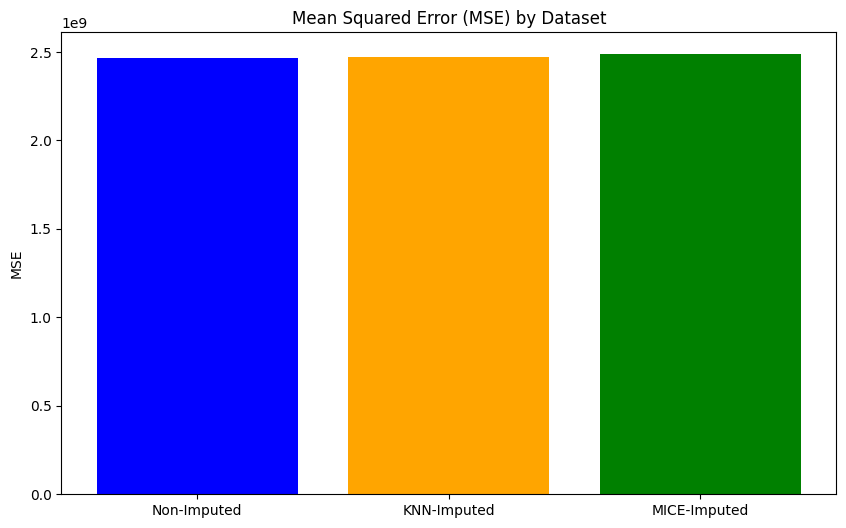

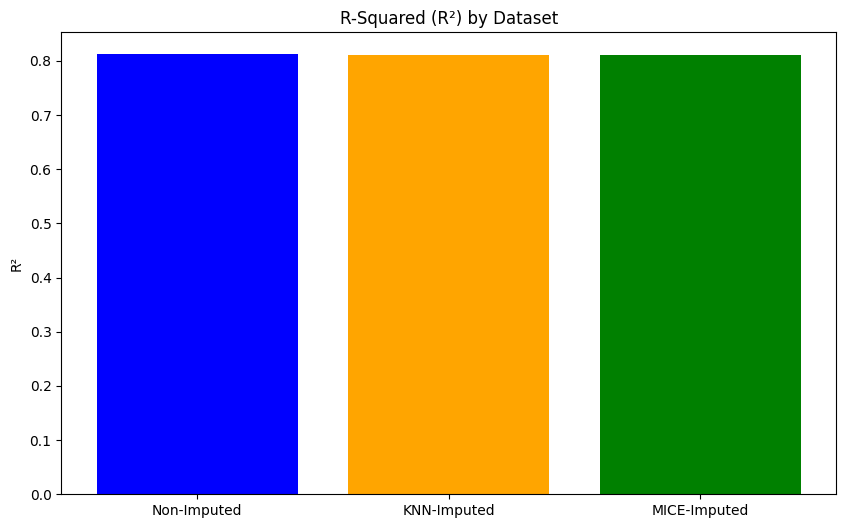

In [33]:
# Extract MSE and R2 values
labels = list(results.keys())
mse_values = [results[label]["MSE"] for label in labels]
r2_values = [results[label]["R2"] for label in labels]

# Plot MSE
plt.figure(figsize=(10, 6))
plt.bar(labels, mse_values, color=["blue", "orange", "green"])
plt.title("Mean Squared Error (MSE) by Dataset")
plt.ylabel("MSE")
plt.show()

# Plot R2
plt.figure(figsize=(10, 6))
plt.bar(labels, r2_values, color=["blue", "orange", "green"])
plt.title("R-Squared (R²) by Dataset")
plt.ylabel("R²")
plt.show()

These boxplots show that the median value appears to be consistent across all of the datasets thus, indicating that both KNN and MICE imputation did in fact preserve the central tendency of the features. The size of the IQR is nearly identical across all three datasets. Additonally, the whiskers represent the range of non-outlier data points and across all three datasets the imputation did not significantly distort the majority of the values. The non-imputed and KNN-Imputed dataset show a similar number of outliers however, the MICE-Imputed dataset appears to introduce or keep additional outliers compared to the other two datasets for median_income.

### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation